In [1]:
import arrayfire as af
import numpy as np
import torch as torch

In [2]:
from pycocotools.coco import COCO
dataDir='/datasets01/COCO/022719/'
dataType='train2017'
annFile='{}/annotations/instances_{}.json'.format(dataDir,dataType)
coco=COCO(annFile)

loading annotations into memory...
Done (t=17.29s)
creating index...
index created!


In [104]:
from torch import nn
import box_ops
def convert_to_xywh(boxes):
    xmin, ymin, xmax, ymax = boxes.unbind(1)
    return torch.stack((xmin, ymin, xmax - xmin, ymax - ymin), dim=1)

def prepare_for_coco_detection(predictions):
        coco_results = []
        for original_id, prediction in predictions.items():
            if len(prediction) == 0:
                continue

            boxes = prediction["boxes"]
            #boxes = convert_to_xywh(boxes).tolist()
            scores = prediction["scores"].tolist()
            labels = prediction["labels"].tolist()

            coco_results.extend(
                [
                    {
                        "image_id": original_id,
                        "category_id": labels[k],
                        "bbox": box,
                        "score": scores[k],
                    }
                    for k, box in enumerate(boxes)
                ]
            )
        return coco_results

class PostProcess(nn.Module):
    """ This module converts the model's output into the format expected by the coco api"""
    @torch.no_grad()
    def forward(self, out_logits, out_bbox, target_sizes):
        """ Perform the computation
        Parameters:
            outputs: raw outputs of the model
            target_sizes: tensor of dimension [batch_size x 2] containing the size of each images of the batch
                          For evaluation, this must be the original image size (before any data augmentation)
                          For visualization, this should be the image size after data augment, but before padding
        """
        # out_logits, out_bbox = outputs['pred_logits'], outputs['pred_boxes']
        print(len(out_logits))
        print(len(target_sizes))
        assert len(out_logits) == len(target_sizes)
        assert target_sizes.shape[1] == 2

        prob = F.softmax(out_logits, -1)
        scores, labels = prob[..., :-1].max(-1)

        # convert to [x0, y0, x1, y1] format
        boxes = box_ops.box_cxcywh_to_xyxy(out_bbox)
        # and from relative [0, 1] to absolute [0, height] coordinates
        img_h, img_w = target_sizes.unbind(1)
        scale_fct = torch.stack([img_w, img_h, img_w, img_h], dim=1)
        boxes = boxes * scale_fct[:, None, :]

        results = [{'scores': s, 'labels': l, 'boxes': b} for s, l, b in zip(scores, labels, boxes)]

        return results
    
class PostProcessLabel(nn.Module):
    """ This module converts the model's output into the format expected by the coco api"""
    @torch.no_grad()
    def forward(self, labels, out_bbox, target_sizes):
        """ Perform the computation
        Parameters:
            outputs: raw outputs of the model
            target_sizes: tensor of dimension [batch_size x 2] containing the size of each images of the batch
                          For evaluation, this must be the original image size (before any data augmentation)
                          For visualization, this should be the image size after data augment, but before padding
        """

        # convert to [x0, y0, x1, y1] format
        print(out_bbox.shape)
        print(out_bbox)
        boxes = box_ops.box_cxcywh_to_xyxy(out_bbox)
        print(boxes)
        print(boxes.shape)
        # and from relative [0, 1] to absolute [0, height] coordinates
        img_h, img_w = target_sizes.unbind(1)
        scale_fct = torch.stack([img_w, img_h, img_w, img_h], dim=1)
        print(scale_fct)
        print(scale_fct.shape)
        print(boxes)
        boxes = boxes * scale_fct[:, None, :]
        print(boxes)
        print(labels)
        print(labels.shape)
        labels = labels[:, :, 0]
        scores = np.ones(labels.shape) 
        results = [{'scores': s, 'labels': l, 'boxes': b} for s, l, b in zip(scores, labels, boxes)]

        return results
        
        """
        # out_logits, out_bbox = outputs['pred_logits'], outputs['pred_boxes']

        #assert len(out_logits) == len(target_sizes)
        #assert target_sizes.shape[1] == 2

        # convert to [x0, y0, x1, y1] format
        print(out_bbox.shape)
        boxes = box_ops.box_cxcywh_to_xyxy(out_bbox)
        # and from relative [0, 1] to absolute [0, height] coordinates
        #img_h, img_w = target_sizes.unbind(1)
        img_h, img_w = imageSizes
        scale_fct = torch.stack([img_w, img_h, img_w, img_h], dim=0)
        print(scale_fct.shape)
        print(boxes.shape)
        boxes = boxes * scale_fct[None, :]
        results = [{'scores': s, 'labels': l, 'boxes': b} for s, l, b in zip(scores, labels, boxes)]
        return results
        """

In [105]:
def readOutput(f):
    imageSizes = af.read_array(f, key='imageSizes').to_ndarray()
    imageSizes = np.transpose(imageSizes, (1, 0))
    imageSizes = torch.from_numpy(imageSizes)

    imageIds = af.read_array(f, key='imageIds').to_ndarray()
    #print(imageIds.shape)
    #imageIds = np.transpose(imageIds, (1, 0))
    scores = af.read_array(f, key='scores').to_ndarray()
    scores = np.transpose(scores, (2, 1, 0))
    scores = torch.from_numpy(scores)
    bboxes = af.read_array(f, key='bboxes').to_ndarray()
    bboxes = np.transpose(bboxes, (2, 1, 0))
    bboxes = torch.from_numpy(bboxes)
    return (imageSizes, imageIds, scores, bboxes)

In [106]:
def readLabel(f):
    imageSizes = af.read_array(f, key='imageSizes').to_ndarray()
    imageSizes = np.expand_dims(imageSizes, 1)
    imageSizes = np.transpose(imageSizes, (1, 0))
    imageSizes = torch.from_numpy(imageSizes)
    imageIds = af.read_array(f, key='imageIds').to_ndarray()
    #imageIds = np.expand_dims(imageIds, 1)
    #imageIds = np.transpose(imageIds, (1, 0))
    scores = af.read_array(f, key='scores').to_ndarray()
    scores = np.expand_dims(scores, 2)
    #scores = np.transpose(scores, (1, 0))
    scores = np.transpose(scores, (2, 1, 0))
    scores = torch.from_numpy(scores)
    bboxes = af.read_array(f, key='bboxes').to_ndarray()
    print(bboxes.shape)
    bboxes = np.expand_dims(bboxes, 2)
    bboxes = np.transpose(bboxes, (2, 1, 0))
    bboxes = torch.from_numpy(bboxes)
    return (imageSizes, imageIds, scores, bboxes)

In [107]:
imageSizes, imageIds, scores, bboxes = readLabel('/private/home/padentomasello/data/coco/scratch/labels.array')

(4, 8)


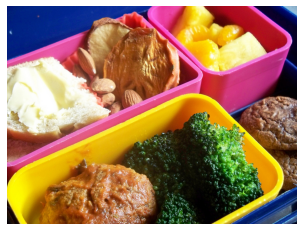

In [108]:
import skimage.io as io
import matplotlib.pyplot as plt
imageId = imageIds[0]
img_url = coco.loadImgs([imageId])[0]['coco_url']

I = io.imread(img_url)
plt.axis('off')
plt.imshow(I)
plt.show()

In [109]:
#### import torch.nn.functional as F
postprocess = PostProcessLabel()
results = postprocess.forward(scores, bboxes, imageSizes)
imageIds = [ id for id in imageIds ];

res = { id : output for id, output in zip(imageIds, results) };

torch.Size([1, 8, 4])
tensor([[[ 0.4786,  0.4933,  0.9539,  0.2045],
         [ 0.4930,  0.2427,  0.0118,  0.4674],
         [ 0.4421,  0.4941,  0.1041,  0.0329],
         [ 0.3394,  0.4048,  0.6789,  0.7534],
         [ 0.3529,  0.0905, -0.4698,  0.0129],
         [ 0.4093,  0.0892, -0.6370,  0.0160],
         [ 0.3670,  0.1502, -0.4714, -0.0066],
         [ 0.3584,  0.0766, -0.4208,  0.1429]]])
tensor([[[0.0017, 0.3910, 0.9556, 0.5955],
         [0.4871, 0.0090, 0.4989, 0.4764],
         [0.3900, 0.4776, 0.4941, 0.5106],
         [0.0000, 0.0281, 0.6789, 0.7815],
         [0.5878, 0.0841, 0.1180, 0.0969],
         [0.7278, 0.0812, 0.0907, 0.0972],
         [0.6027, 0.1535, 0.1313, 0.1469],
         [0.5688, 0.0052, 0.1481, 0.1481]]])
torch.Size([1, 8, 4])
tensor([[640, 480, 640, 480]])
torch.Size([1, 4])
tensor([[[0.0017, 0.3910, 0.9556, 0.5955],
         [0.4871, 0.0090, 0.4989, 0.4764],
         [0.3900, 0.4776, 0.4941, 0.5106],
         [0.0000, 0.0281, 0.6789, 0.7815],
         [

In [110]:
threshold = 0.2
results = prepare_for_coco_detection(res)
print(results[0])
results = [ result for result in results if result['score'] > threshold]
len(results)

{'image_id': 9, 'category_id': 51.0, 'bbox': tensor([  1.0800, 187.6900, 611.5900, 285.8400]), 'score': 1.0}


8

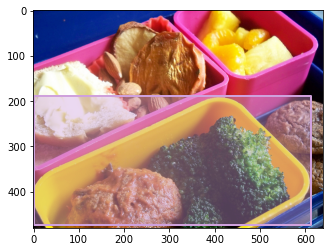

In [111]:
##### cocoDt=coco.loadRes([results[0]])
plt.imshow(I);
annIds = cocoDt.getAnnIds([imageId])
anns = cocoDt.loadAnns(annIds)
coco.showAnns(anns)

Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!


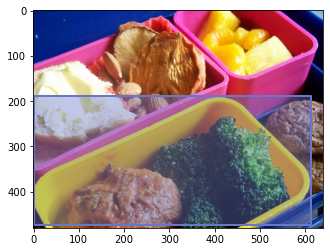

In [112]:
results2 = [{
    'image_id': 9,
    'category_id': 51.0,
    'bbox': [1.08, 187.69, 611.59, 285.84],
    'score': 1.0
}]
cocoDt=coco.loadRes(results2)
plt.imshow(I);
annIds = cocoDt.getAnnIds([imageId])
anns = cocoDt.loadAnns(annIds)
coco.showAnns(anns)

In [113]:
results[0]

{'image_id': 9,
 'category_id': 51.0,
 'bbox': tensor([  1.0800, 187.6900, 611.5900, 285.8400]),
 'score': 1.0}

In [114]:
results2

[{'image_id': 9,
  'category_id': 51.0,
  'bbox': [1.08, 187.69, 611.59, 285.84],
  'score': 1.0,
  'segmentation': [[1.08,
    187.69,
    1.08,
    473.53,
    612.6700000000001,
    473.53,
    612.6700000000001,
    187.69]],
  'area': 174816.88559999998,
  'id': 1,
  'iscrowd': 0}]